# __Egg sales of a local shop in Sri Lanka - An elementary analysis__

Ilina Durakovska 221017

In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import kagglehub

import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller

from scipy import signal

from pandas.plotting import autocorrelation_plot
from scipy.stats import f_oneway

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

## Loading the data and minimal pre-processing

In [6]:
# data = pd.read_csv('train_egg_sales.csv', sep=';')

In [12]:
path = kagglehub.dataset_download("kanchana1990/egg-sales-of-a-local-shop-for-30-years")
path = path + '/train_egg_sales.csv'

In [20]:
data = pd.read_csv(path, sep=';')

In [24]:
data["Date"] = pd.to_datetime(data['Date'])

data.head()

,Date,Egg Sales
0,1993-01-01,91
1,1993-01-02,124
2,1993-01-03,112
3,1993-01-04,115
4,1993-01-05,107


In [26]:
# size of dataset
data.count() 

Date         10592
Egg Sales    10592
dtype: int64

In [28]:
# check for null values 
data.isnull().sum()

Date         0
Egg Sales    0
dtype: int64

# __Visualization__

In [9]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Egg Sales', dpi=100, tick_interval='yearly'):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')

    # Format the x-axis
    ax = plt.gca()

    # Choose tick frequency based on user selection
    if tick_interval == 'yearly':
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    elif tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # rotate for readability
    
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.tight_layout()
    plt.show()

In [10]:
def get_last_x_years(df, num_years=5): 
    dev = 30 // num_years
    num = len(df) // dev
    
    data_last_x = df.tail(num)
    data_last_x = data_last_x.reset_index(drop=True)
    
    return data_last_x

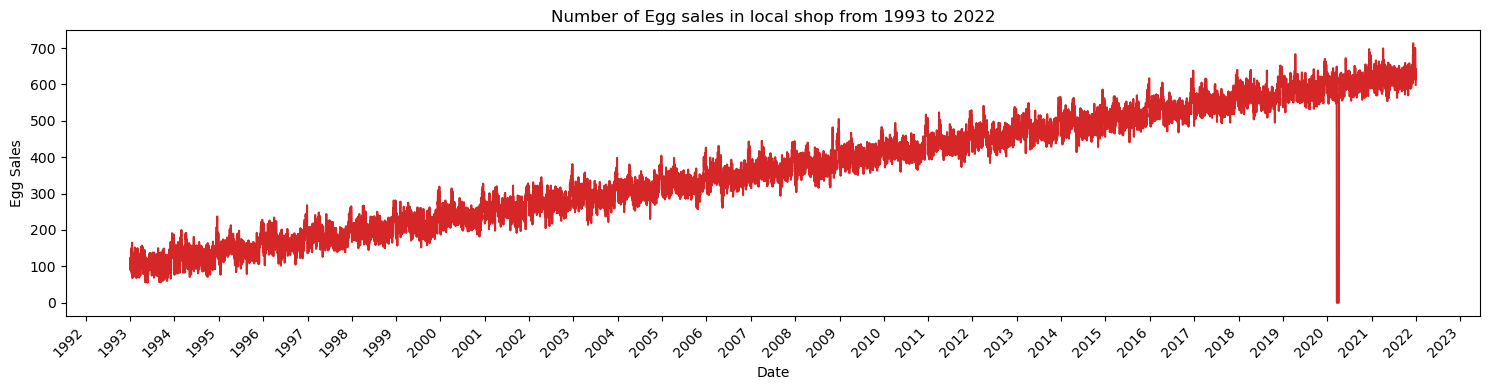

In [11]:
plot_df(data, x=data['Date'], y=data['Egg Sales'], title='Number of Egg sales in local shop from 1993 to 2022')

##### Because the dataset is quite large (it includes records of sales for 30 years), I've decided to work with the data of the last 10 years or so, just to better visualize the seasonal and or cyclic components.

In [13]:
data_last_10 = get_last_x_years(data, 10)

data_last_10.head()

,Date,Egg Sales
0,2012-05-03,435
1,2012-05-04,468
2,2012-05-05,446
3,2012-05-06,448
4,2012-05-07,425


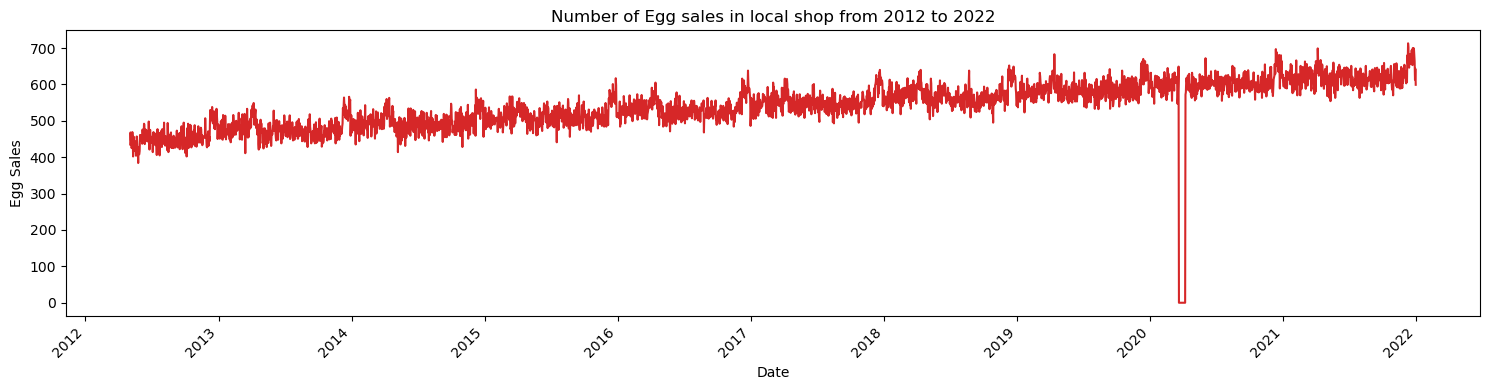

In [14]:
plot_df(data_last_10, x=data_last_10['Date'], y=data_last_10['Egg Sales'], title='Number of Egg sales in local shop from 2012 to 2022')

Clearer, but let's try the last five years...

In [16]:
data_last_5 = get_last_x_years(data, 5)

data_last_5.head()

,Date,Egg Sales
0,2017-03-03,605
1,2017-03-04,590
2,2017-03-05,593
3,2017-03-06,549
4,2017-03-07,532


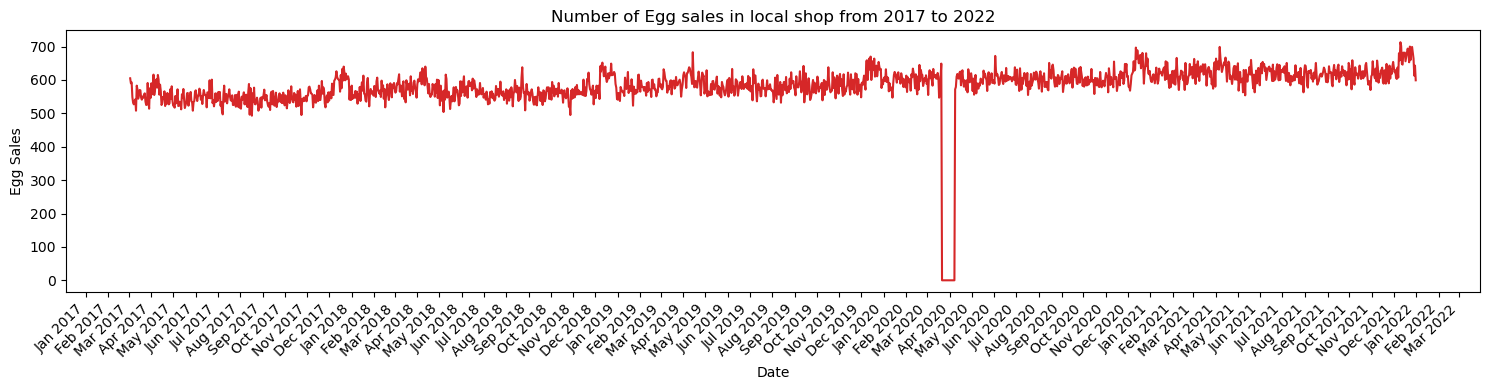

In [17]:
plot_df(data_last_5, x=data_last_5['Date'], y=data_last_5['Egg Sales'], title='Number of Egg sales in local shop from 2017 to 2022', tick_interval='monthly')

And let's also check the last three years...

In [19]:
data_last_3 = get_last_x_years(data, 3)

data_last_3.head()

,Date,Egg Sales
0,2019-02-07,579
1,2019-02-08,574
2,2019-02-09,553
3,2019-02-10,591
4,2019-02-11,564


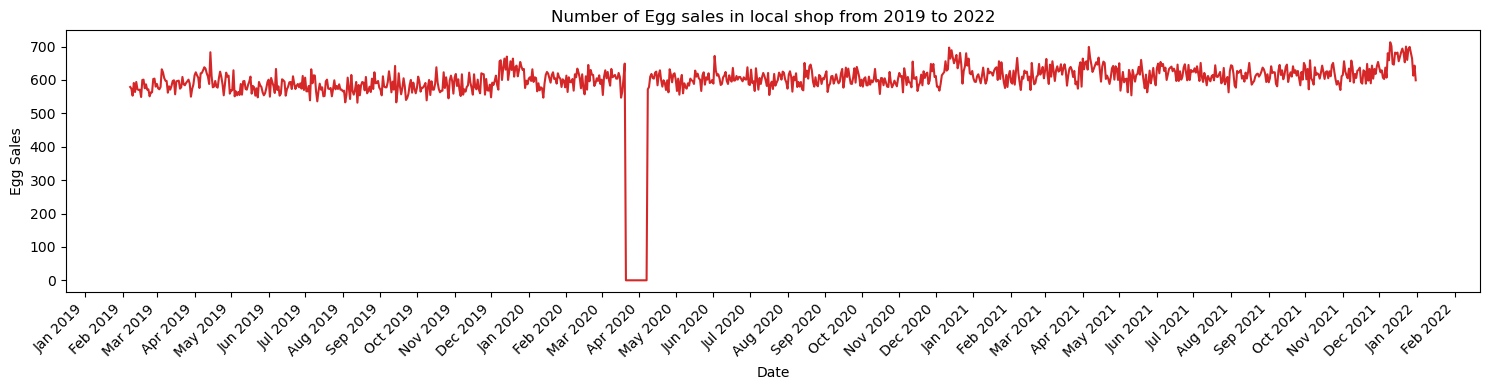

In [20]:
plot_df(data_last_3, x=data_last_3['Date'], y=data_last_3['Egg Sales'], title='Number of Egg sales in local shop from 2019 to 2022', tick_interval='monthly')

Now that we have a general sense of what the data shows, we can start analysing properly...

# __Analysis__

## Decomposition

By viewing the plotted graphs we have, we can already assume that the time series is additive, because the seasonal fluctuations remain relatively constant when the trend rises, but we can try decomposing them with both the multiplicative and additive approaches and see what we get.

In [25]:
def additive_decompose(df):
    additive_decomposition = seasonal_decompose(df['Egg Sales'], model='additive', period=365)

    plt.rcParams.update({'figure.figsize': (16,12)})
    additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

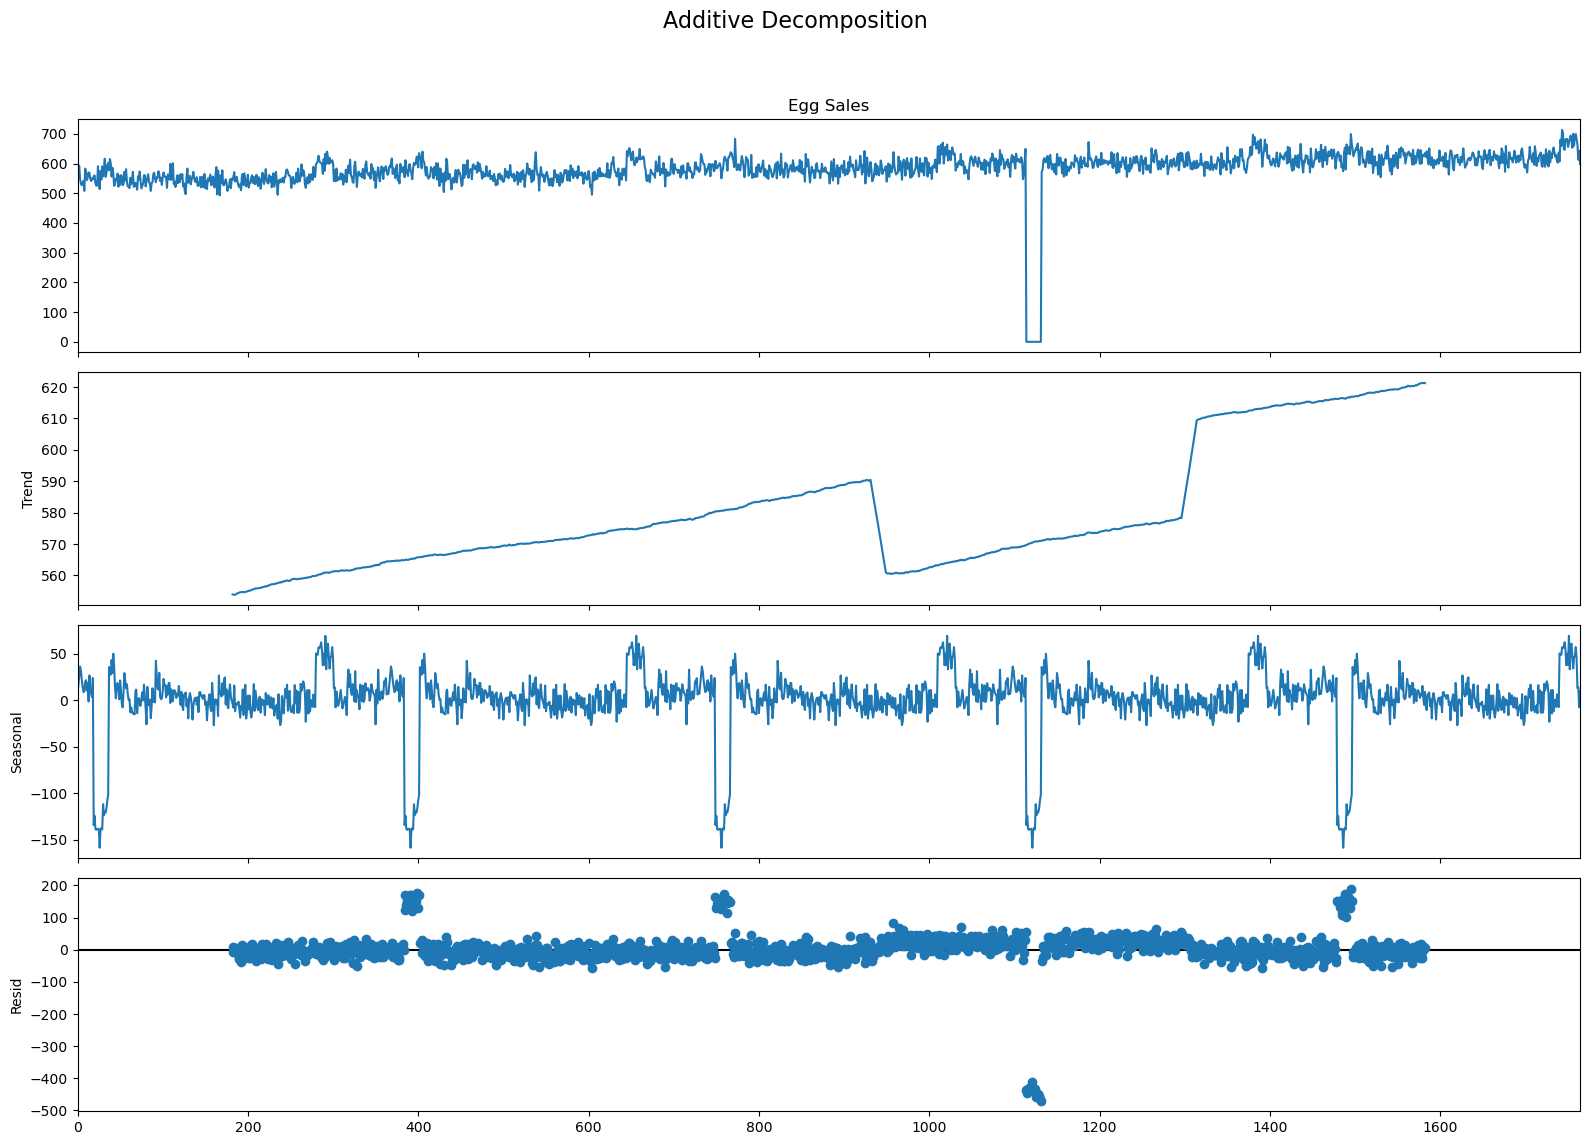

In [26]:
additive_decompose(data_last_5)

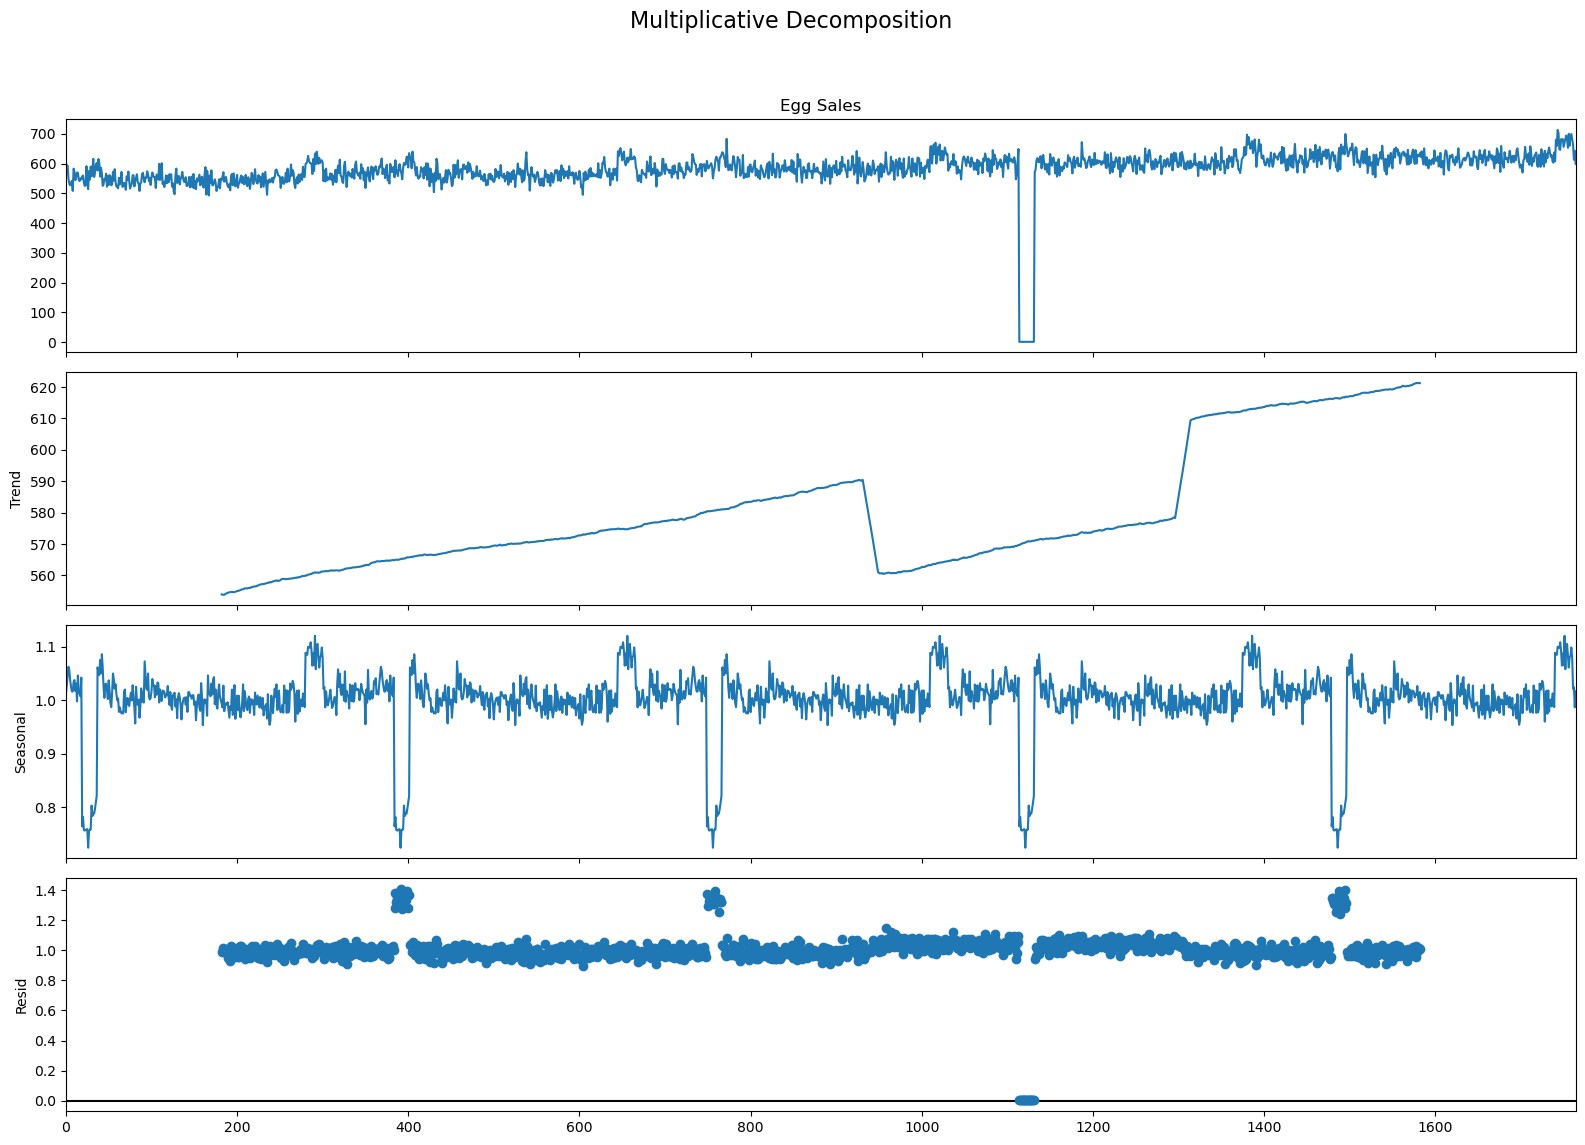

In [27]:
data_fixed = data_last_5['Egg Sales'].copy()
data_fixed[data_fixed <= 0] = 1

multiplicative_decomposition = seasonal_decompose(data_fixed, model='multiplicative', period=365)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

_What we see here confirms my previous assumption. We want the residuals to be random and close to 0, in the multiplicative decomposition this is not the case._

We can clearly see that we have seasonality in the series and that it's interval is yearly, and even before the decomposition, we see a clear linear rising trend present in the data.

__Note on the 0 values in 2020:__ As we all know, around april 2020 the global covid pandemic led to the shutdown of many if not all non-essential businesses for a time period. This is very visible in the plotted charts and explains the sudden drop to 0 in april-may of 2020.

But even in the additive decomposition, there's something going on with the residuals, we still see some form of "seasonality". My guess is that te sudden drop to 0 in the covid period influences this in the decomposition model, so lets try fixing this by interpolating the initial data.

In [32]:
data_interpolated = data.copy()

data_interpolated['Egg Sales'] = data_interpolated['Egg Sales'].replace(0, np.nan)
data_interpolated['Egg Sales'] = data_interpolated['Egg Sales'].interpolate(method='linear')

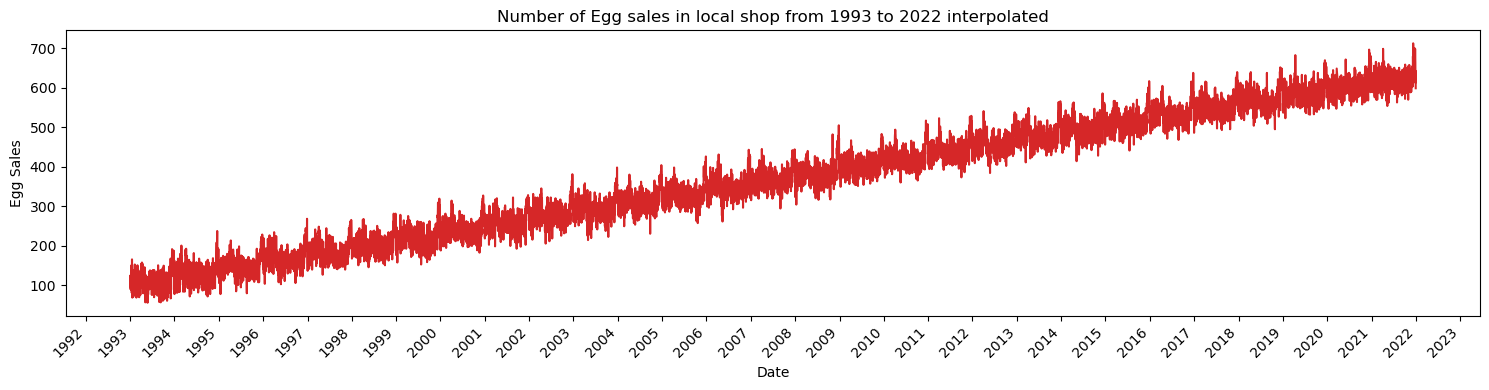

In [33]:
plot_df(data_interpolated, x=data_interpolated['Date'], y=data_interpolated['Egg Sales'], title='Number of Egg sales in local shop from 1993 to 2022 interpolated')

In [34]:
data_interp_last_5 = get_last_x_years(data_interpolated)

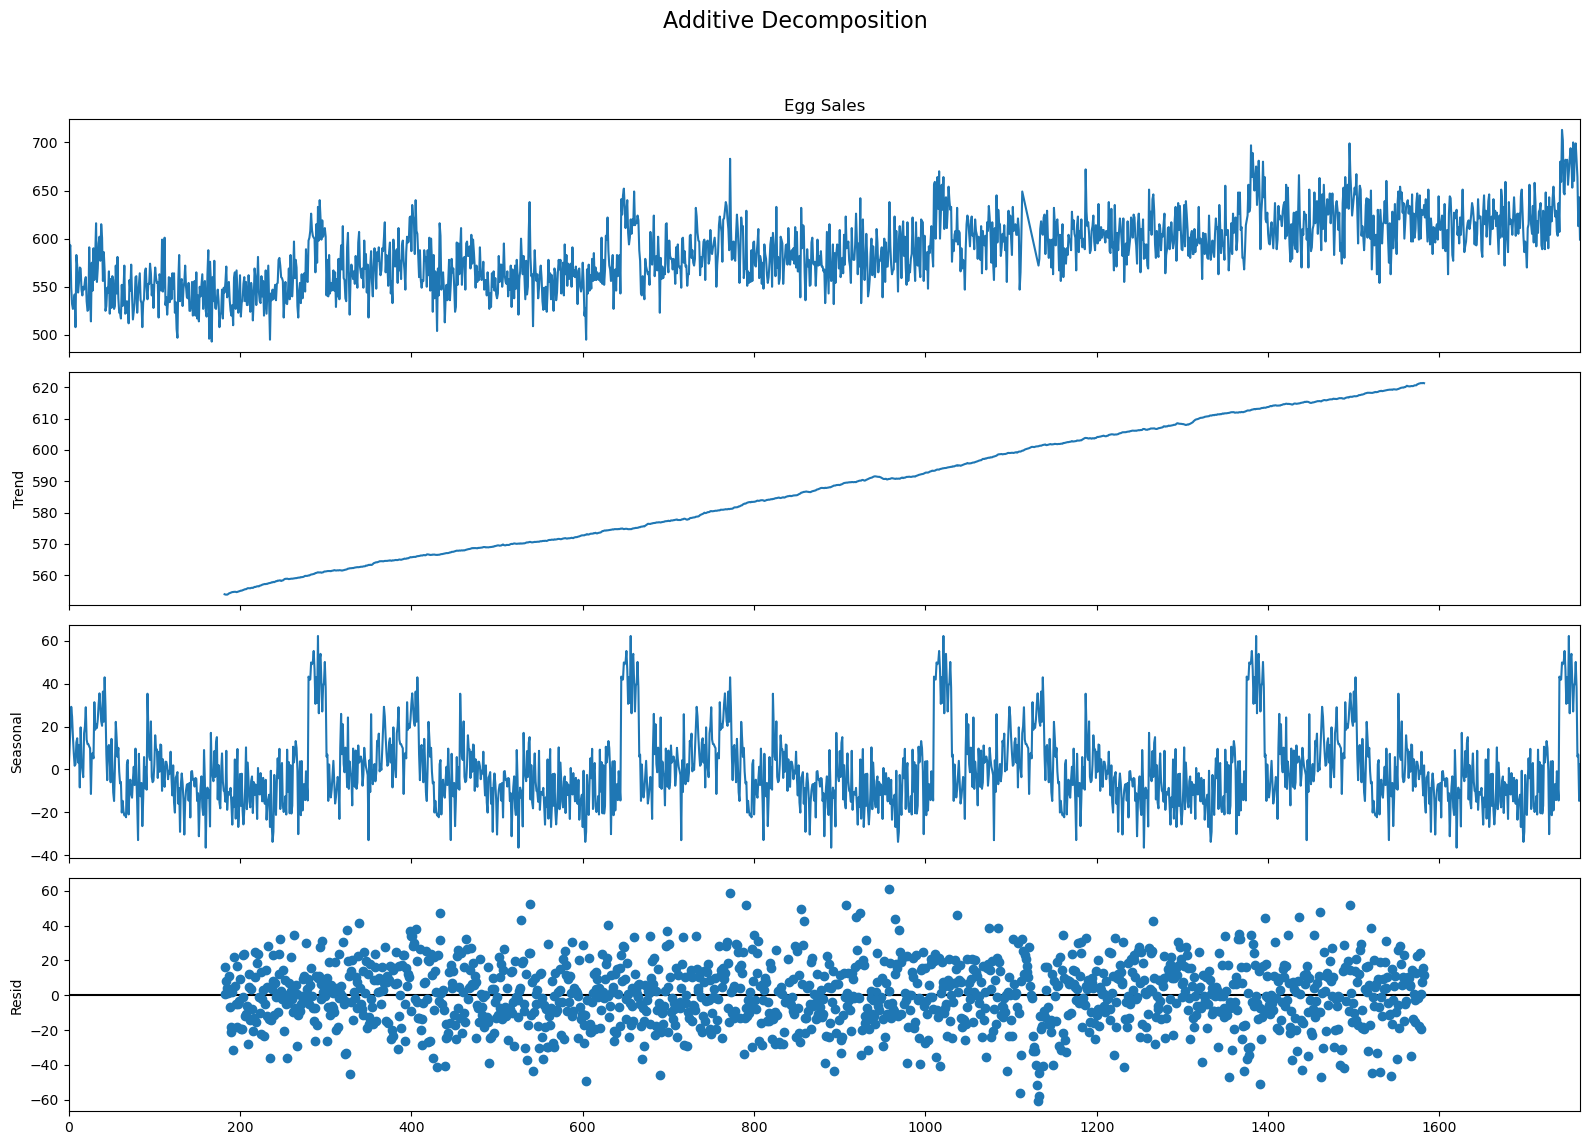

In [35]:
additive_decompose(data_interp_last_5)

Now this is exactly what we want to see, a clear trend line, clear seasonal pattern and residuals that are random and close to 0!

Let's also just take a look at the whole dataset:

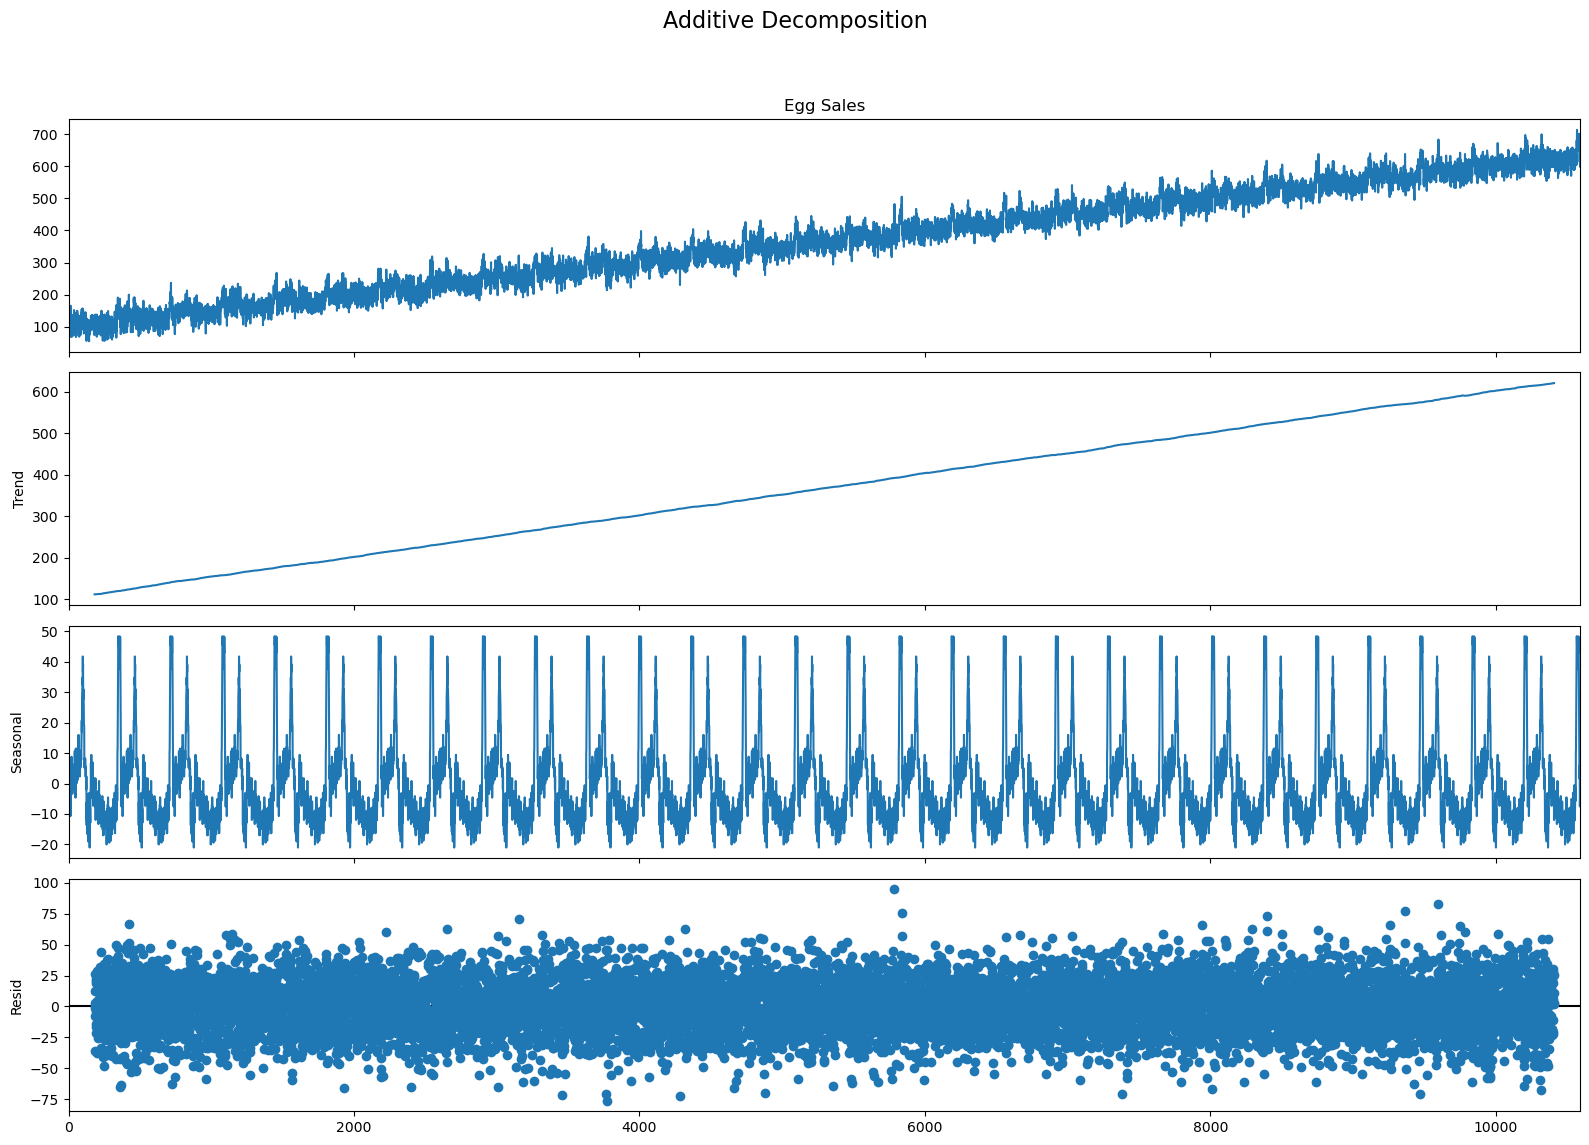

In [38]:
additive_decompose(data_interpolated)

Again, excellent results!

## Stationarity

Looking at the plots, I suspect the series we have is not stationary, mainly because i can see that the mean value risies over time, so lests test if my hypothesis is correct...

### Testing for stationarity - ADF test 

In [43]:
def check_stationarity_adf(df):
    adf_result = adfuller(df['Egg Sales'])

    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Stationary!' if adf_result[1] < 0.05 else 'Non-stationary!')

In [44]:
check_stationarity_adf(data_interpolated)

ADF Statistic: -0.7504437157473484
p-value: 0.8332474133822296
Non-stationary!


We see that the series as a whole is in fact non-stationary, but what if we look at a smaller segment of the series? The mean wouldn't vary as much and perhaps the result will suggest stationarity...

In [46]:
check_stationarity_adf(data_interp_last_5)

ADF Statistic: -3.4941127560796494
p-value: 0.0081395845200309
Stationary!


Exactly as i expected, looking at a smaller segment, the test suggests stationarity (though we inch closer to the alpha value).

## Detrending

As before seen, we have a clear rising trend present in the series, so lets try to remove it.

First thing we can try is removing the trend component from the previous results of the decompositioning, knowing that we have a additive time series:

In [51]:
def detrend_decompose(df, show_plot=True):
    result_mul = seasonal_decompose(df['Egg Sales'], model='additive', period=365)
    
    detrended_df = pd.DataFrame({
        'Date': df['Date'],
        'Egg Sales': df['Egg Sales'] - result_mul.trend
    })
    
    detrended_df = detrended_df.dropna().reset_index(drop=True)
    
    if show_plot:
        plt.figure(figsize=(14, 6))
        plt.plot(detrended_df['Date'], detrended_df['Egg Sales'])
        plt.title('Egg sales detrended by subtracting the trend component', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Detrended Sales')
        plt.show()
    
    return detrended_df

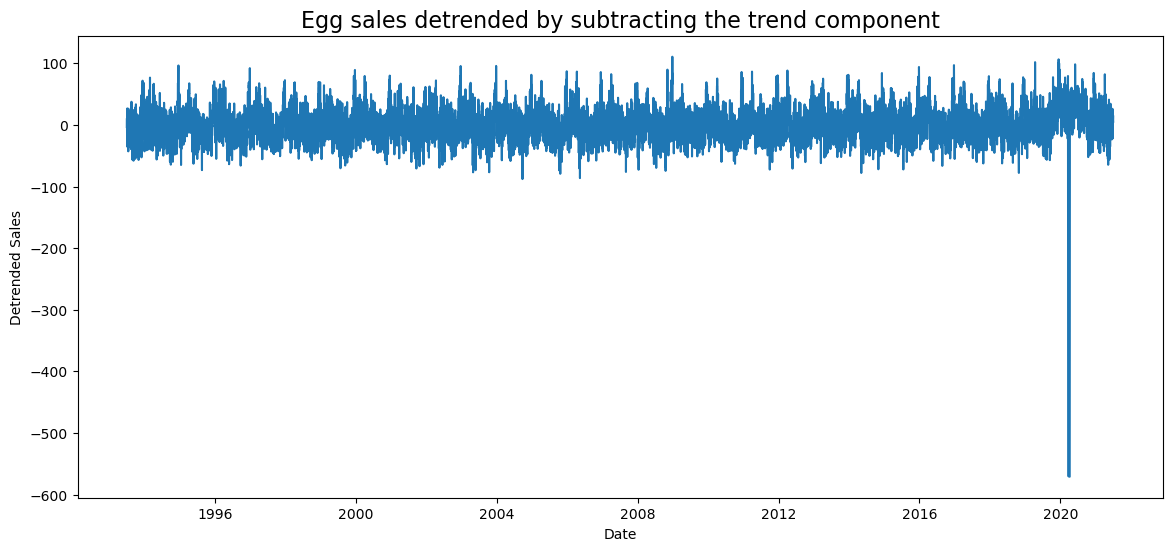

In [52]:
_ = detrend_decompose(data)

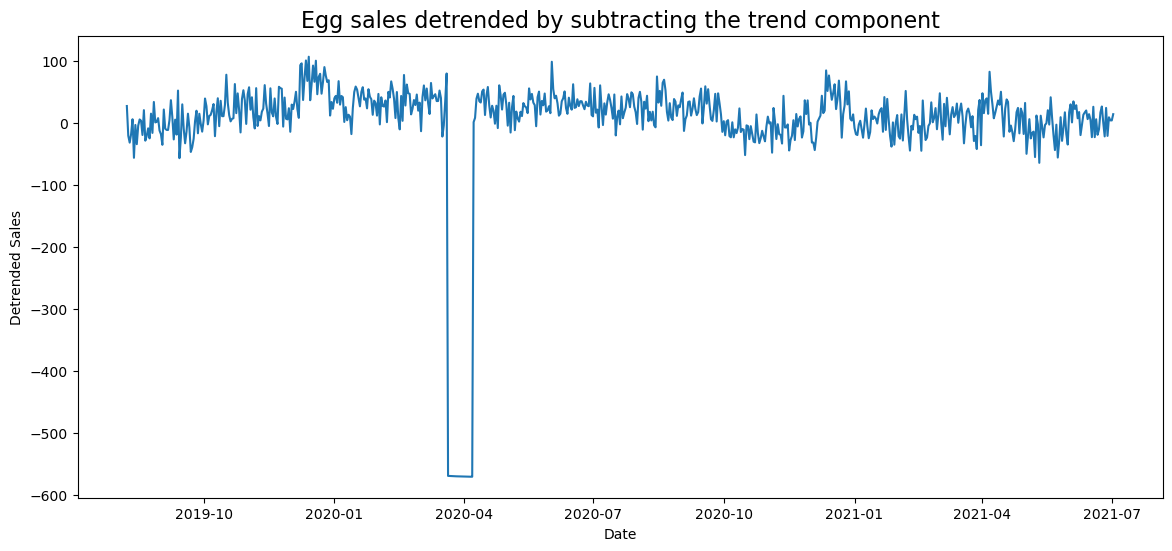

In [53]:
_ = detrend_decompose(data_last_3)

We see it works quite well, especially on the larger scale. 

We can also try detrending by subtracting the line of best fit:

In [56]:
def detrend_lbf(df, show_plot=True):
    detrended_values = signal.detrend(df['Egg Sales'].values)
    
    detrended_df = pd.DataFrame({
        'Date': df['Date'].values,
        'Egg Sales': detrended_values
    })
    
    if show_plot:
        plt.figure(figsize=(14, 6))
        plt.plot(detrended_df['Date'], detrended_df['Egg Sales'])
        plt.title('Egg sales detrended by subtracting the least squares fit', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Detrended Sales')
        plt.show()
    
    return detrended_df

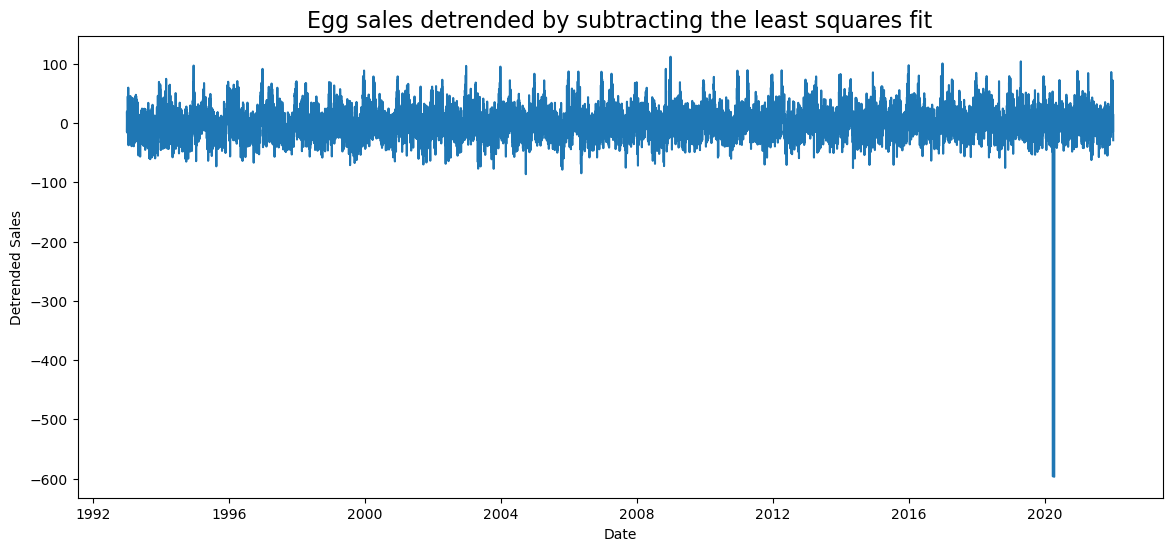

In [57]:
_ = detrend_lbf(data)

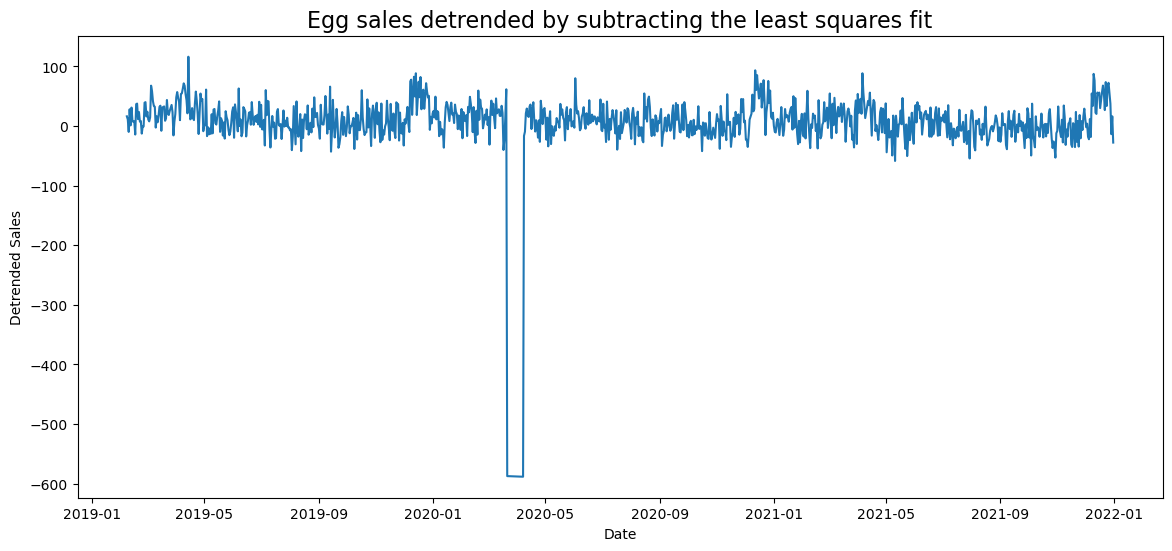

In [58]:
_ = detrend_lbf(data_last_3)

The results are basically the same for the whole set. By the looks of it the line of best fit method works slightly better for smaller sub-segments of this series.

My guess for why the lbf method works better for the smaller segments is that, in the last 3 years the drop to 0 because of the closure related to covid messes with the trend when decomposing, and the lbf method adjusts better for this drop.

## Deseasonilizing

In the various plots from the last couple of years, we can clearly see a repeating yearly segment indicating seasonality, but lets formally check for it using a statistical test and visually showing it on a heatmap:

In [63]:
def check_for_seasonality(df):
    # Extract month and year from the Date column
    temp = df.copy()
    temp['Month'] = df['Date'].dt.month
    temp['Year'] = df['Date'].dt.year
    
    # Monthly averages by year
    monthly_avg = temp.groupby(['Year', 'Month'])['Egg Sales'].mean().unstack()
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(monthly_avg, cmap='YlOrRd', annot=True, fmt='.0f')
    plt.title('Monthly Average Sales by Year - Consistent patterns = Seasonality')
    plt.show()
    
    # Statistical test on months
    groups = [group['Egg Sales'].values for name, group in temp.groupby('Month')]
    stat, p_value = f_oneway(*groups)
    print(f'ANOVA F-statistic: {stat:.4f}')
    print(f'p-value: {p_value:.6f}')
    print('Significant monthly differences (yearly pattern)!' if p_value < 0.05 else 'No significant pattern')

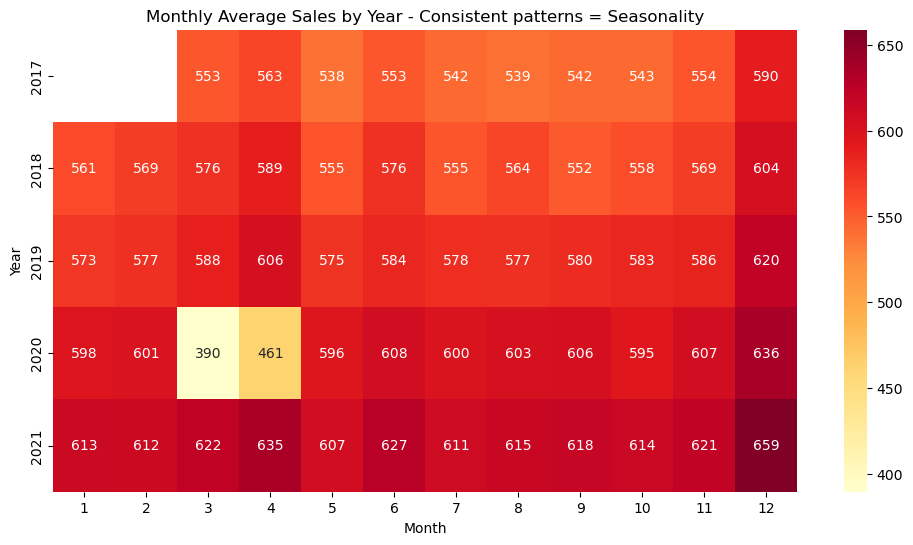

ANOVA F-statistic: 10.3195
p-value: 0.000000
Significant monthly differences (yearly pattern)!


In [64]:
check_for_seasonality(data_last_5)

Now that we statistically can see there is a seasonal monthly element, let's try deseasonalizing the series.

In [66]:
def deseasonalize(df):
    result_addit = seasonal_decompose(df['Egg Sales'], model='additive', period=365)
    
    deseasonalized = df['Egg Sales'] - result_addit.seasonal
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Original
    axes[0].plot(df['Date'], df['Egg Sales'])
    axes[0].set_title('Original Egg Sales', fontsize=14)
    axes[0].set_ylabel('Sales')
    
    # Deseasonalized
    axes[1].plot(df['Date'], deseasonalized)
    axes[1].set_title('Deseasonalized Egg Sales', fontsize=14)
    axes[1].set_ylabel('Sales')
    
    plt.tight_layout()
    plt.show()

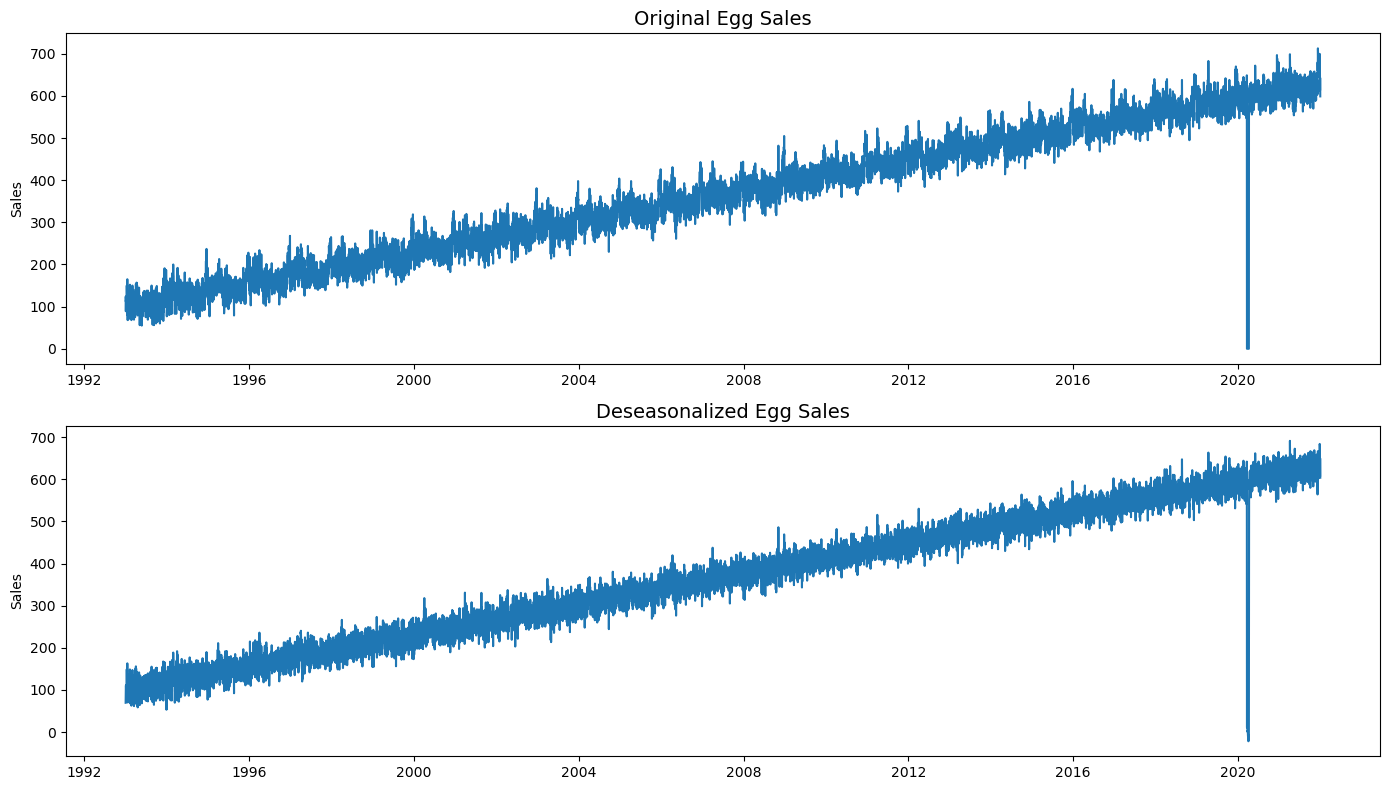

In [67]:
deseasonalize(data)

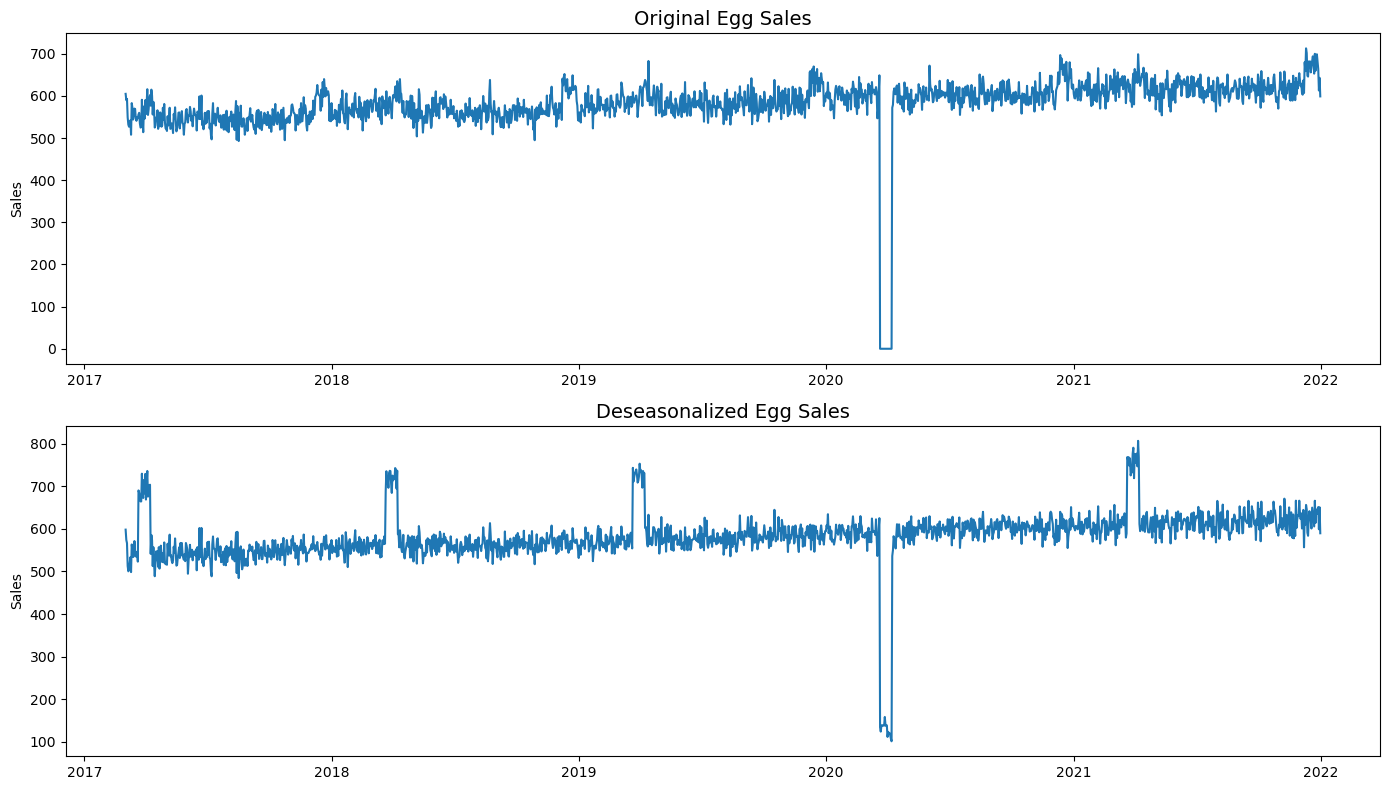

In [68]:
deseasonalize(data_last_5)

The deseasonalization generally worked, with exception to one of the spikes, the issue is obviously the same as before, the sunnen drop influences the model, so the interpolated charts should yeald better results:

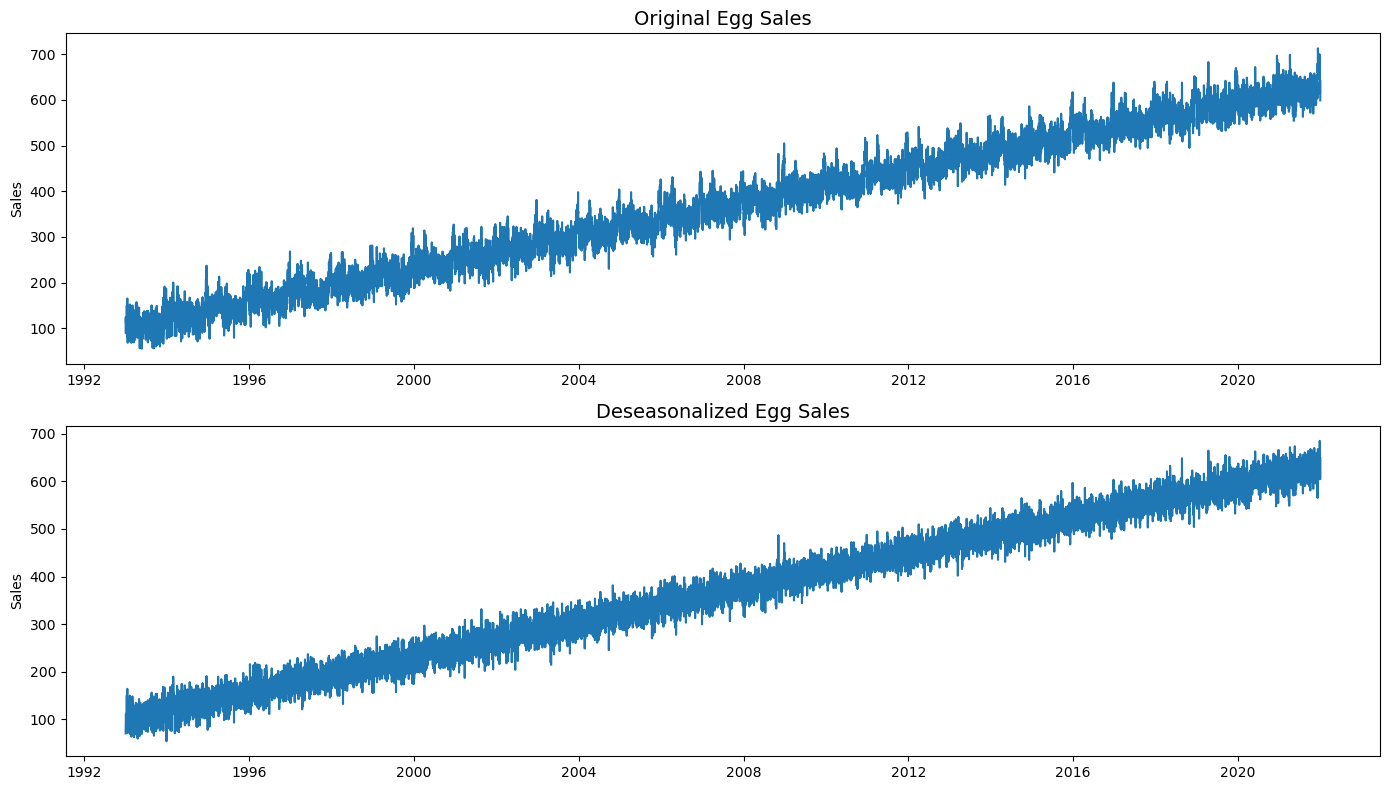

In [70]:
deseasonalize(data_interpolated)

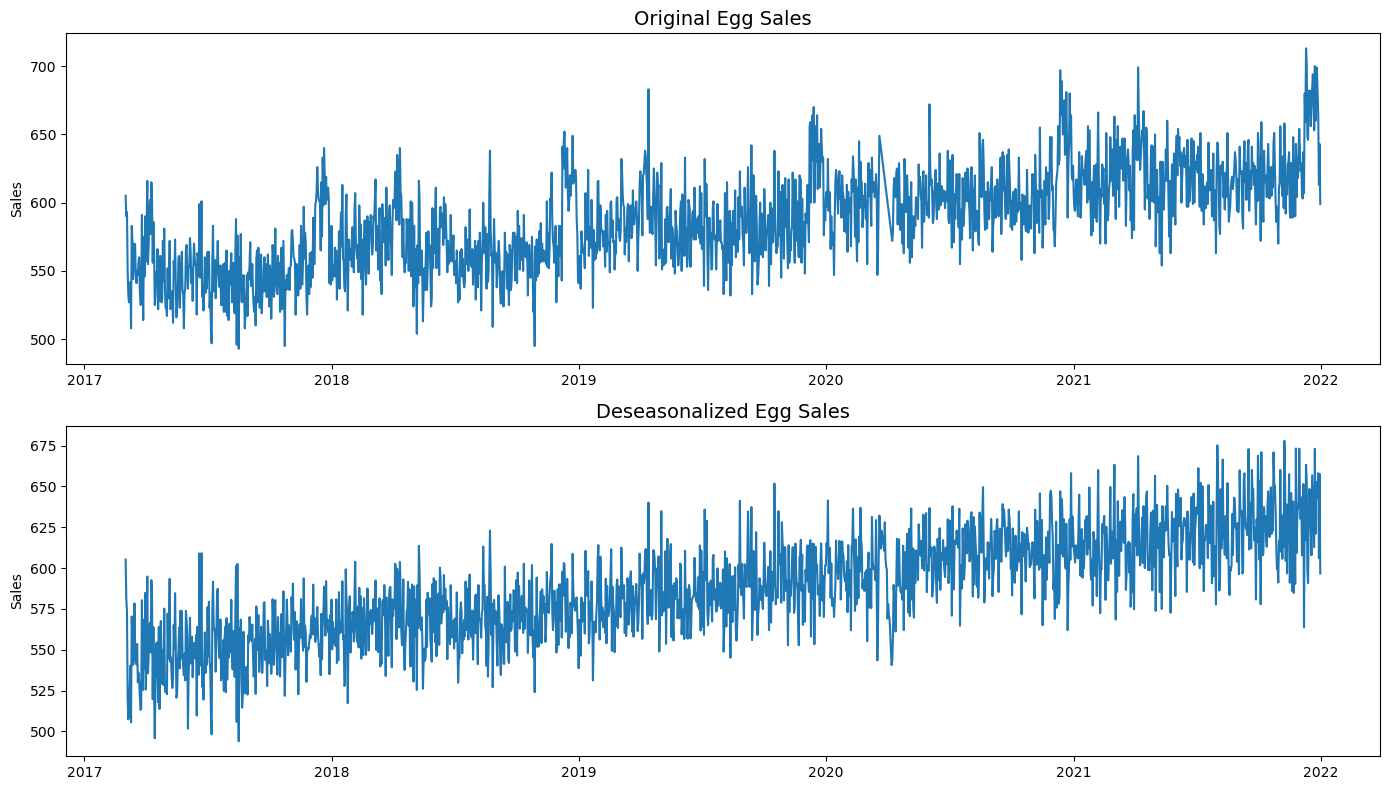

In [71]:
deseasonalize(data_interp_last_5)

Now this is more so what we're looking for, what's leftover is the trend + random noise.

## Autocorrelation and Partial Autocorrelation

Time to see how the local and non local previous values impact the next one, I'll plot the Autocorrelation and Partial Autocorrilation functions:

In [75]:
def acf_and_pacf(df):
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    plot_acf(df['Egg Sales'], lags=400, ax=axes[0])
    plot_pacf(df['Egg Sales'], lags=400, ax=axes[1])
    plt.tight_layout()
    plt.show()
    
    acf_vals = acf(df['Egg Sales'], nlags=365)
    print(f"Key autocorrelations:")
    print(f"Lag 1: {acf_vals[1]:.4f}")
    print(f"Lag 2: {acf_vals[2]:.4f}")
    print(f"Lag 3: {acf_vals[3]:.4f}")
    print(f"Lag 7: {acf_vals[7]:.4f}")
    print(f"Lag 365: {acf_vals[365]:.4f}")

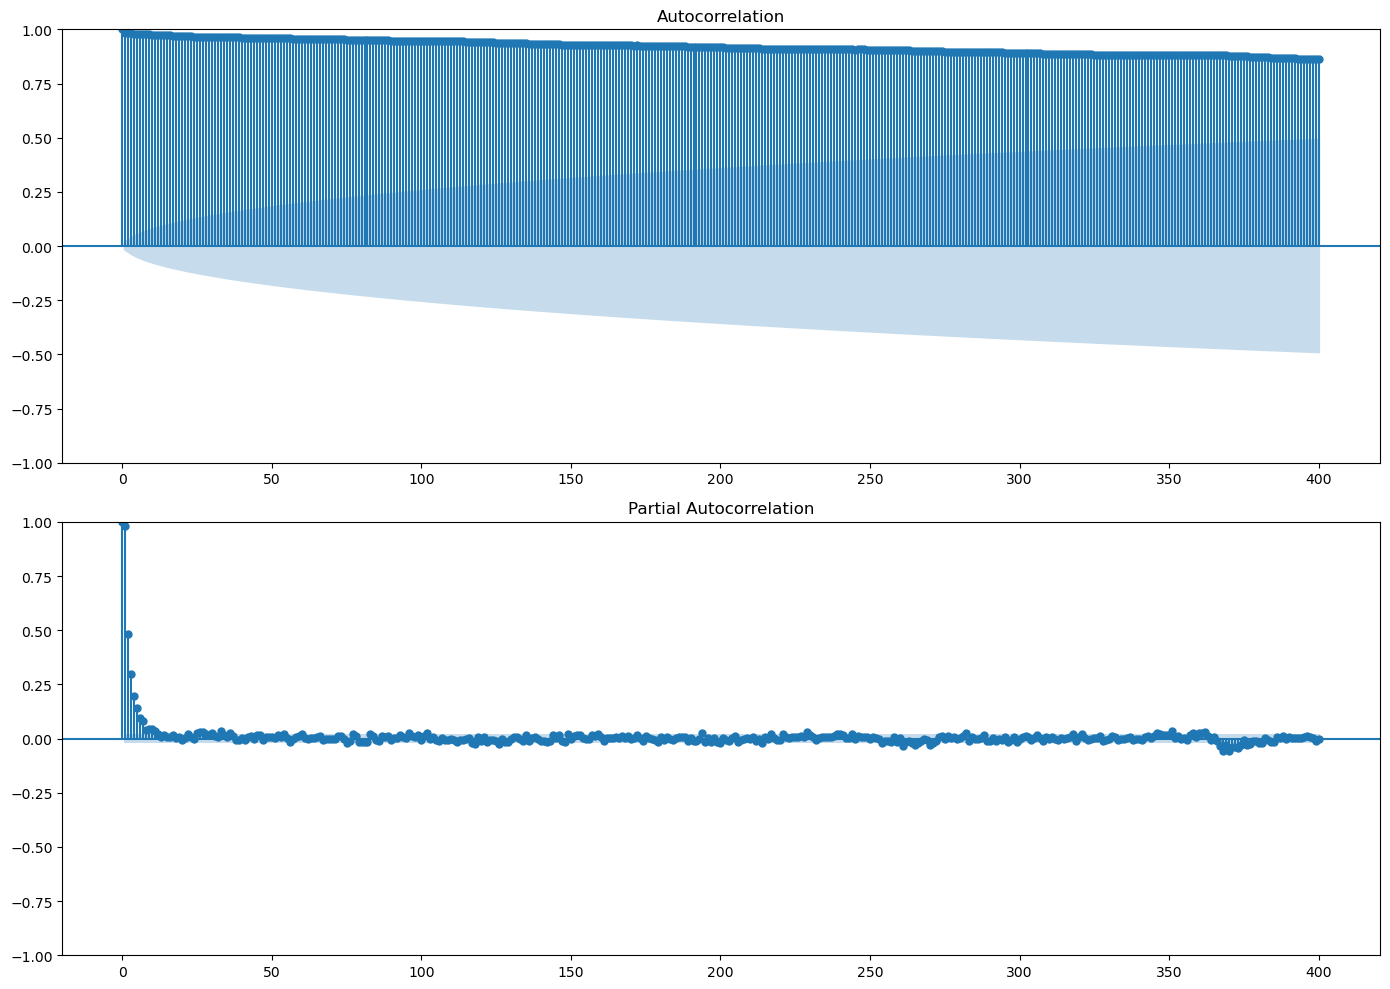

Key autocorrelations:
Lag 1: 0.9824
Lag 2: 0.9819
Lag 3: 0.9812
Lag 7: 0.9781
Lag 365: 0.8823


In [76]:
acf_and_pacf(data_interpolated)

In [77]:
data_interp_last_10 = get_last_x_years(data_interpolated)

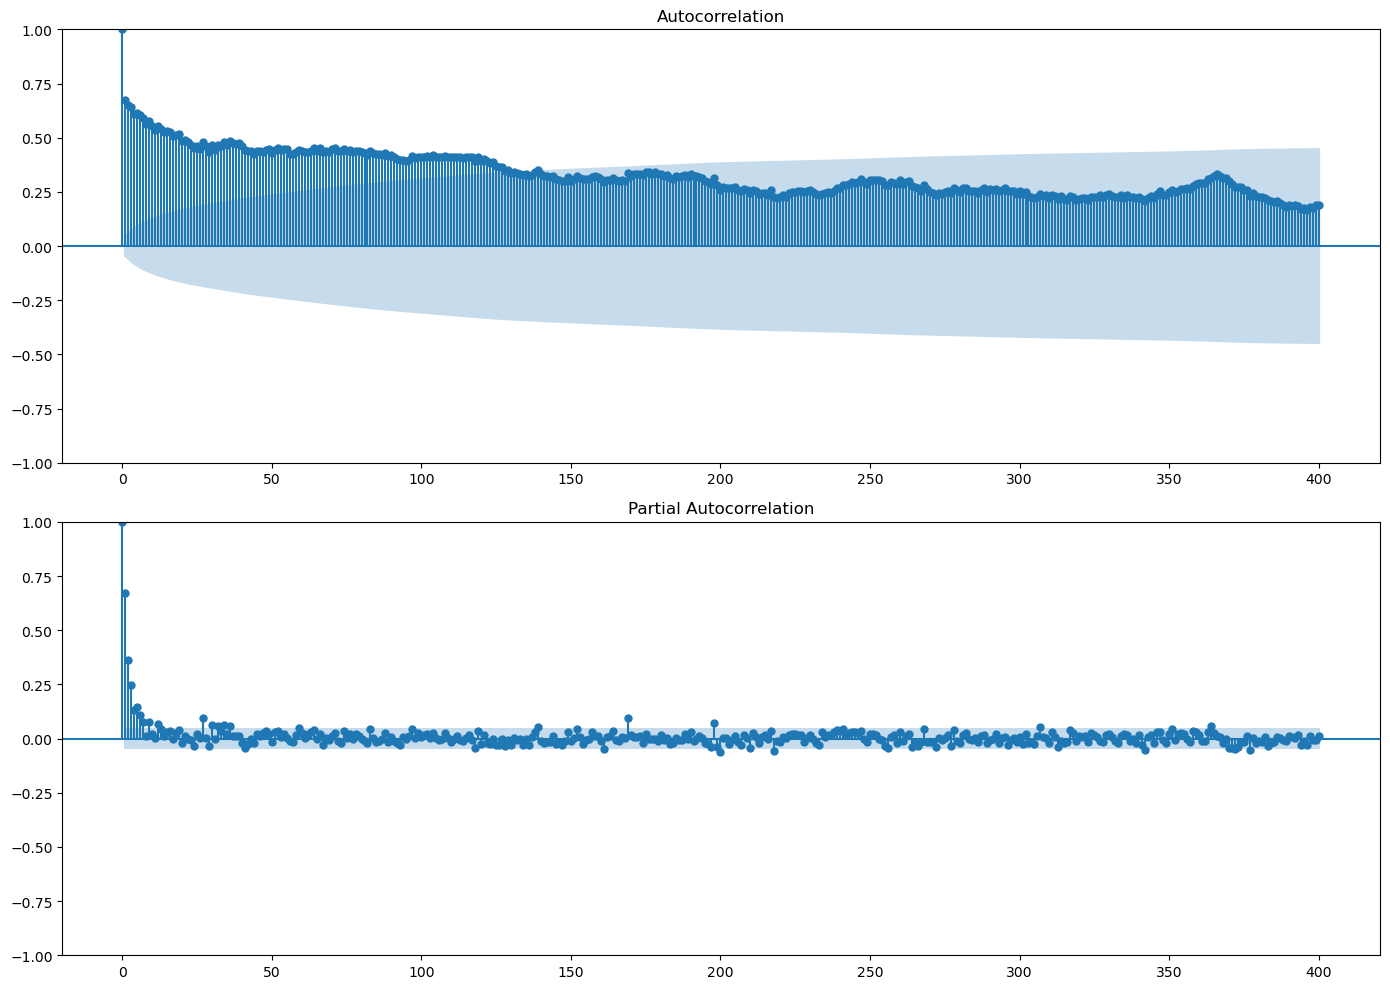

Key autocorrelations:
Lag 1: 0.6725
Lag 2: 0.6514
Lag 3: 0.6412
Lag 7: 0.5931
Lag 365: 0.3239


In [78]:
acf_and_pacf(data_interp_last_10)

Viewing the whole dataset, all values rise and vary in a similar fashon, so it makes sence that the ACP and PACP plots show high correlation though all 400 lags, but when looking at a smaller segment (the last 10 years), we can clearly see a peak in the functions around the 1 year mark and some other peaks noticable in the starter charts. This is likely because of the seasonal factor present in the data.

What if we detrend the data first?

In [81]:
detrended_interpolated_last_10 = detrend_decompose(data_interp_last_10, show_plot=False)

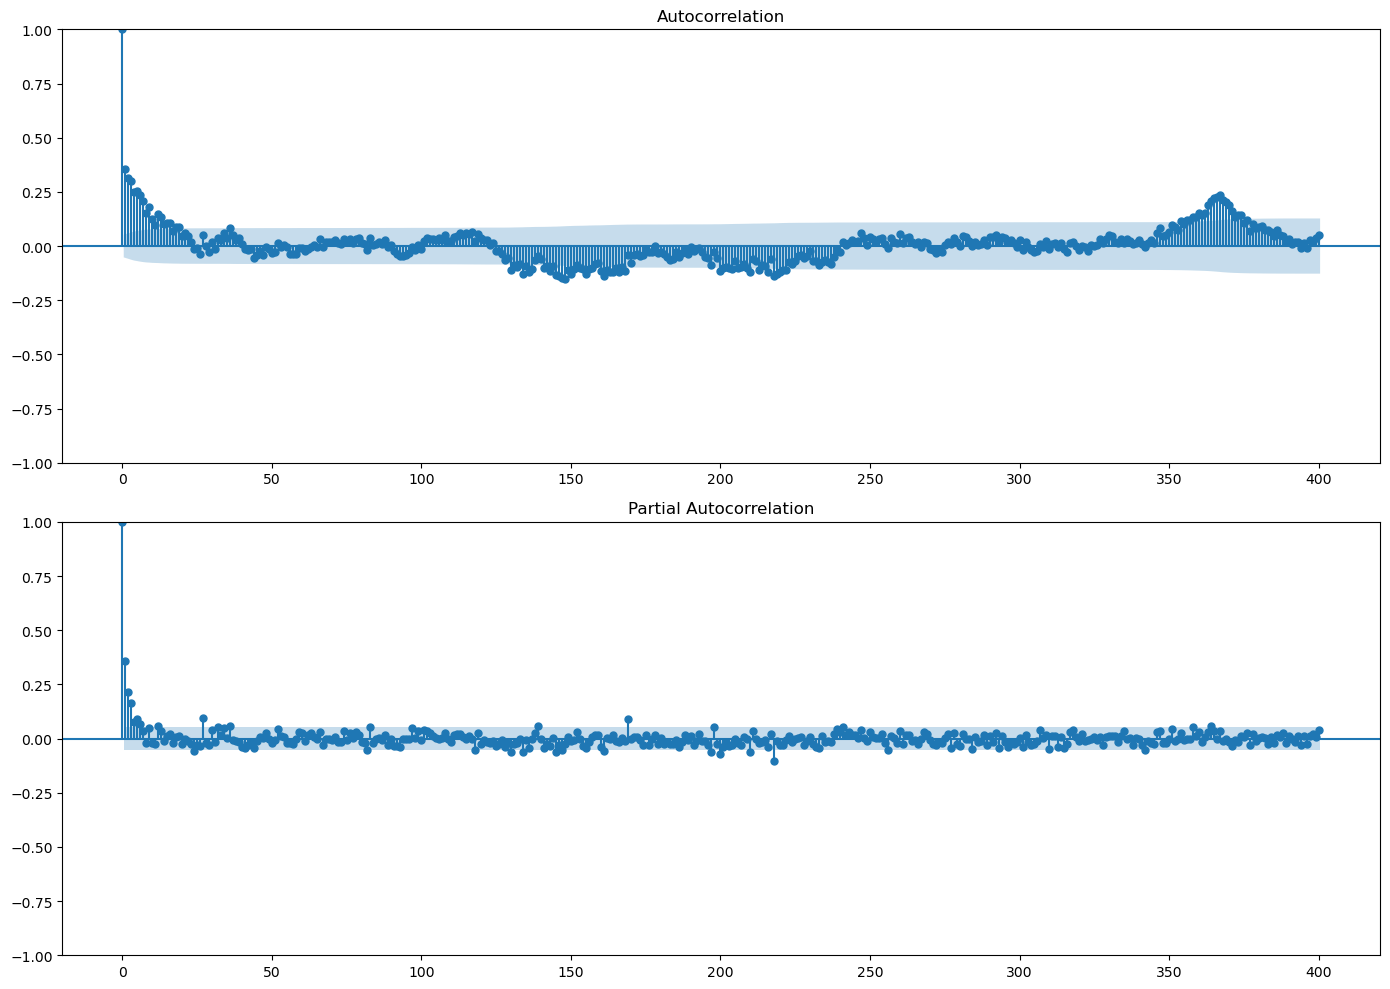

Key autocorrelations:
Lag 1: 0.3569
Lag 2: 0.3145
Lag 3: 0.3004
Lag 7: 0.2066
Lag 365: 0.2209


In [82]:
acf_and_pacf(detrended_interpolated_last_10)

The large peak around the 365 day mark on the Autocorrelation plots lines up with what we would expect, since theres a strong yearly seasonality present - values that are a year appart are quite similar. On the Partial Autocorrelation plot we notice large values for the first couple of steps - this could be useful when deciding the number of lags when training models in the future.

## Smoothing

The first method of smoothing, is just by simply eliminating the residuals when making a seasonal decomposition, what we have left over is the trend and the seasonal aspect:

In [155]:
def remove_noise(df):
    decomp = seasonal_decompose(df['Egg Sales'],  model='additive', period=365)
    without_residual = df['Egg Sales'] - decomp.resid
    
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Egg Sales'],label='Original', alpha=0.5)
    plt.plot(df['Date'], without_residual, label='Without Residual (Trend + Seasonal)', linewidth=2)
    plt.title('Removing Residuals From Original Series')
    plt.legend()
    plt.show()

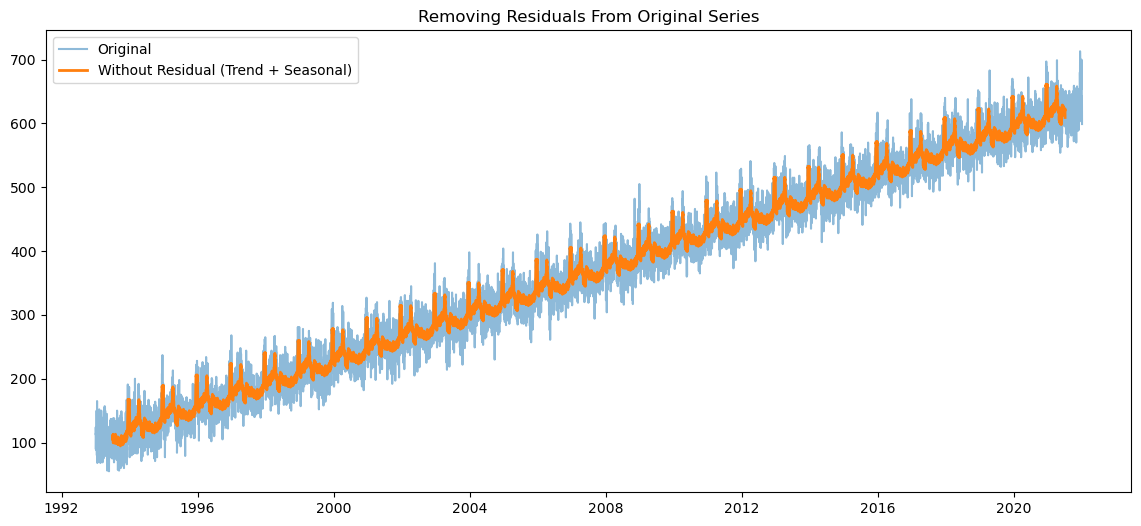

In [157]:
remove_noise(data_interpolated)

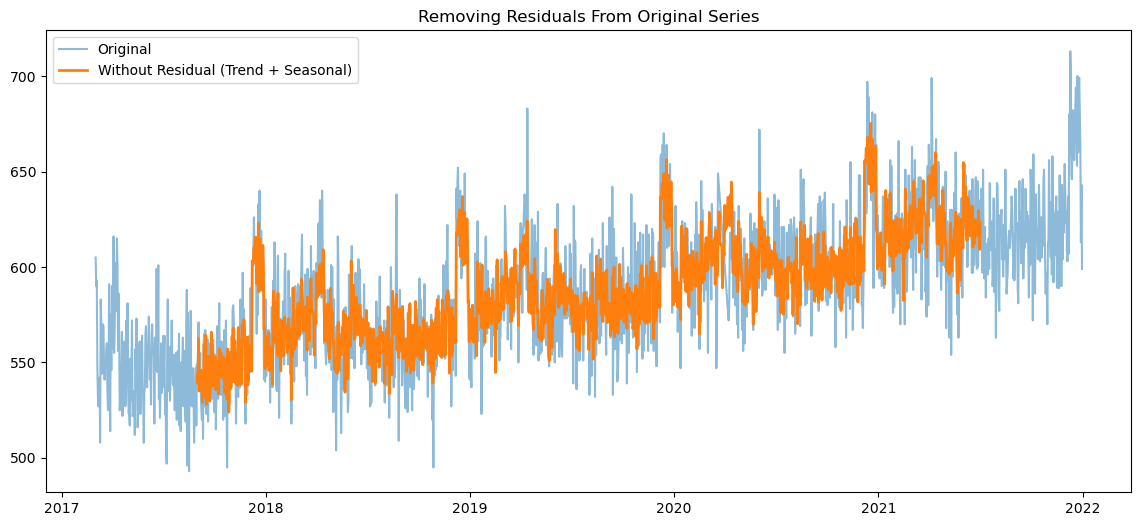

In [164]:
remove_noise(data_interp_last_10)

But this doesn't really "smoothen" our series, it just extracts the noise. 

What we can try next is to take a moving average window with a defined with, ill try it with a 30-day and 7-day window:

In [172]:
def moving_average_smoothing(df, window_size):
    window = window_size 
    df['MA_7'] = df['Egg Sales'].rolling(window=window).mean()
    
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Egg Sales'], label='Original', alpha=0.5)
    plt.plot(df['Date'], df['MA_7'], label=f'{window}-day Moving Average', linewidth=2)
    plt.title('Moving Average Smoothing')
    plt.legend()
    plt.show()

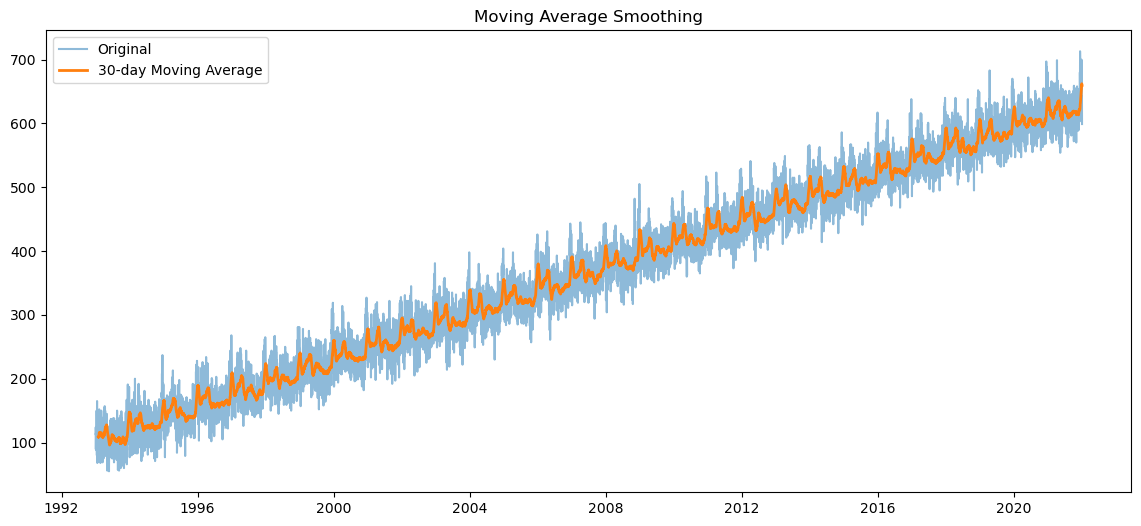

In [174]:
moving_average_smoothing(data_interpolated, 30)

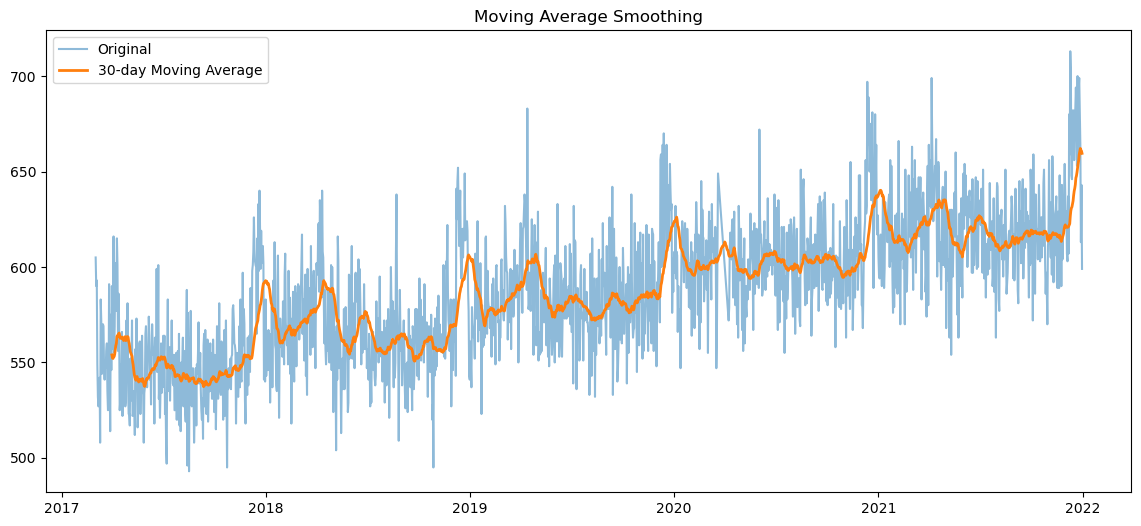

In [176]:
moving_average_smoothing(data_interp_last_10, 30)

The results look pretty good! The noise is significantly redused and the seasonality is in tact but toned down.

Let's see what we get with a weekly rolling window:

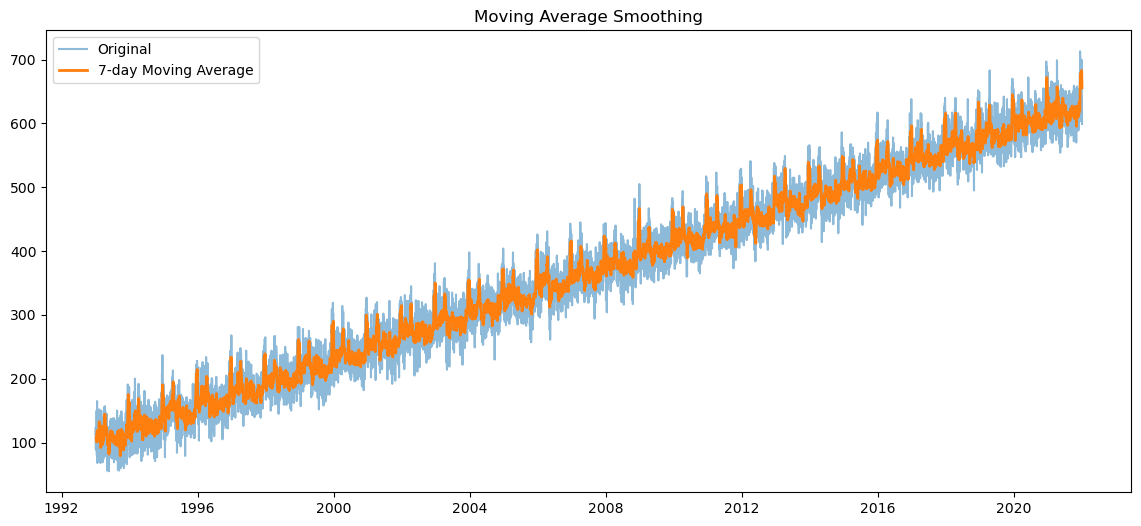

In [180]:
moving_average_smoothing(data_interpolated, 7)

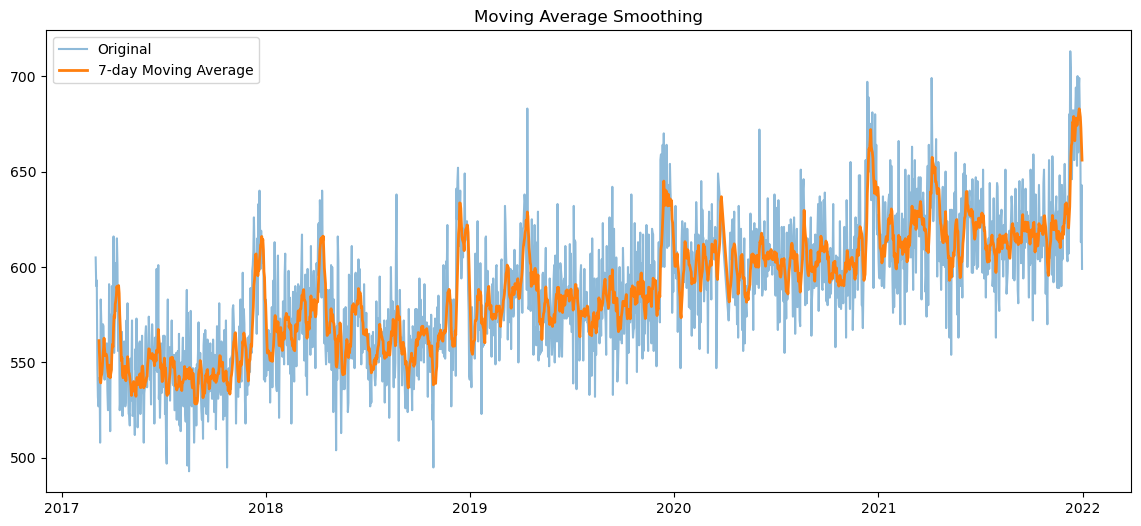

In [182]:
moving_average_smoothing(data_interp_last_10, 7)

The seasonal spikes are definitely more pronounced, but the noise is also reduced. I would say both windows yield acceptable results!

_And that concludes my elementary analysis of this dataset :)_